<center>Первичный анализ данных Instamart_data.csv</center>
    
<center>Выполнил: Мошкин Дмитрий</center>

In [107]:
import pandas as pd
import numpy as np
import scipy
import plotly.graph_objs as go
import seaborn as sns
from matplotlib import pyplot as plt
from plotly.offline import init_notebook_mode, iplot
from scipy import stats

from scipy import stats
from statsmodels.stats.descriptivestats import sign_test
from statsmodels.stats.weightstats import zconfint
from statsmodels.stats.weightstats import *

init_notebook_mode(connected=True)
sns.set_style("whitegrid")
%matplotlib inline

---
Найди все интересные на твой взгляд инсайты и представь их в любом удобном виде.

Обозначения:

- id - ... (очевидно)
- created_at - Дата принятия заказа Инстамартом (пользователь собрал корзину и сделал заказ)
- city - ...
- lat - ...
- lon - ...
- item_total - Сумма позиций в доставке
- cost - Первоначальная стоимость доставки
- retailer_id - ...
- user_id - ....
- total_cost - Стоимость доставки после применения промокода на скидку к доставке (если промокода не было, то cost=total_cost)
- promo_total - Промокод на сумму позиций (скидка непосредственно примененная к товарам)
- total_weight - Вес заказа , г.
- total_quantity - Количество единиц товара
- state - состояние доставки
- shipped_at - Дата доставки заказа
- store_id - ...

---

Инсайты:

- Промо-акция вызывает увеличение частоты мелких (до 1000) и крупных покупок (более 4000)
- Наиболее вероятно, что промо-акция привлекает новые категории покупателей, так как суммы покупок увеличиваются не пропорционально, а  скорее появляются новые сегменты
- Критерий Манна-Уитни отвергает гипотезу, что среднее распределений total_cost с промо и без промо-акции равно.
- Заказы распределены примерно равномерно по дням недели
- Интересно посмотреть на распределение заказов в течении дня. В первую очередь интересно учесть, что какой-то яркой зависимости от дня недели снова нет (например, между выходными и буднями). В тоже время заметно, что график количества заказов имеет пик на 10 утра, группировку вокруг этого часа, затем спад и площадку в 17-18 часов.

Из непонятного:
- Есть позиции, где total_cost выше cost

---

In [128]:
data = pd.read_csv('Instamart_data.csv')

In [129]:
data.head()

,id,created_at,city,lat,lon,item_total,cost,retailer_id,user_id,total_cost,promo_total,total_weight,total_quantity,state,shipped_at,store_id
0,0,2018-08-02 00:01:00,1,55.834381,37.530174,1679,199.0,9,81434.0,190.0,0.0,9745,30,shipped,2018-08-02 08:39:00,30
1,1,2018-08-02 00:09:00,1,55.776063,37.535981,698,299.0,1,NaN,0.0,0.0,500,2,pending,NaN,14
2,2,2018-08-02 00:23:00,1,55.703454,37.467994,1444,299.0,1,30278.0,299.0,0.0,9460,14,canceled,NaN,17
3,3,2018-08-02 00:26:00,1,55.761914,37.565010,1524,299.0,1,103825.0,299.0,0.0,8230,17,shipped,2018-08-07 08:21:00,24
4,4,2018-08-02 00:32:00,1,55.811434,37.496868,9608,299.0,1,9786.0,596.0,0.0,50139,77,shipped,2018-08-02 13:53:00,13


In [130]:
print('NAN in columns: ')
for column in data.columns:
    if any(data[column].isna()):
        
        print(column + ' ' + str(data[column].isna().value_counts()[1]))

NAN in columns: 
lat 22
lon 22
user_id 95745
shipped_at 166670


In [131]:
# Добавим флажок для строк, где было применение купона

data['promo_flag'] = (data['cost'] != data['total_cost']).astype('int')

# Исключим из фрейма отменные заказы

data = data[data['state'] != 'canceled']

# Исключим строки с суммой покупок равной 0

data = data[data['item_total'] != 0]

In [133]:
data.fillna(0, inplace=True)

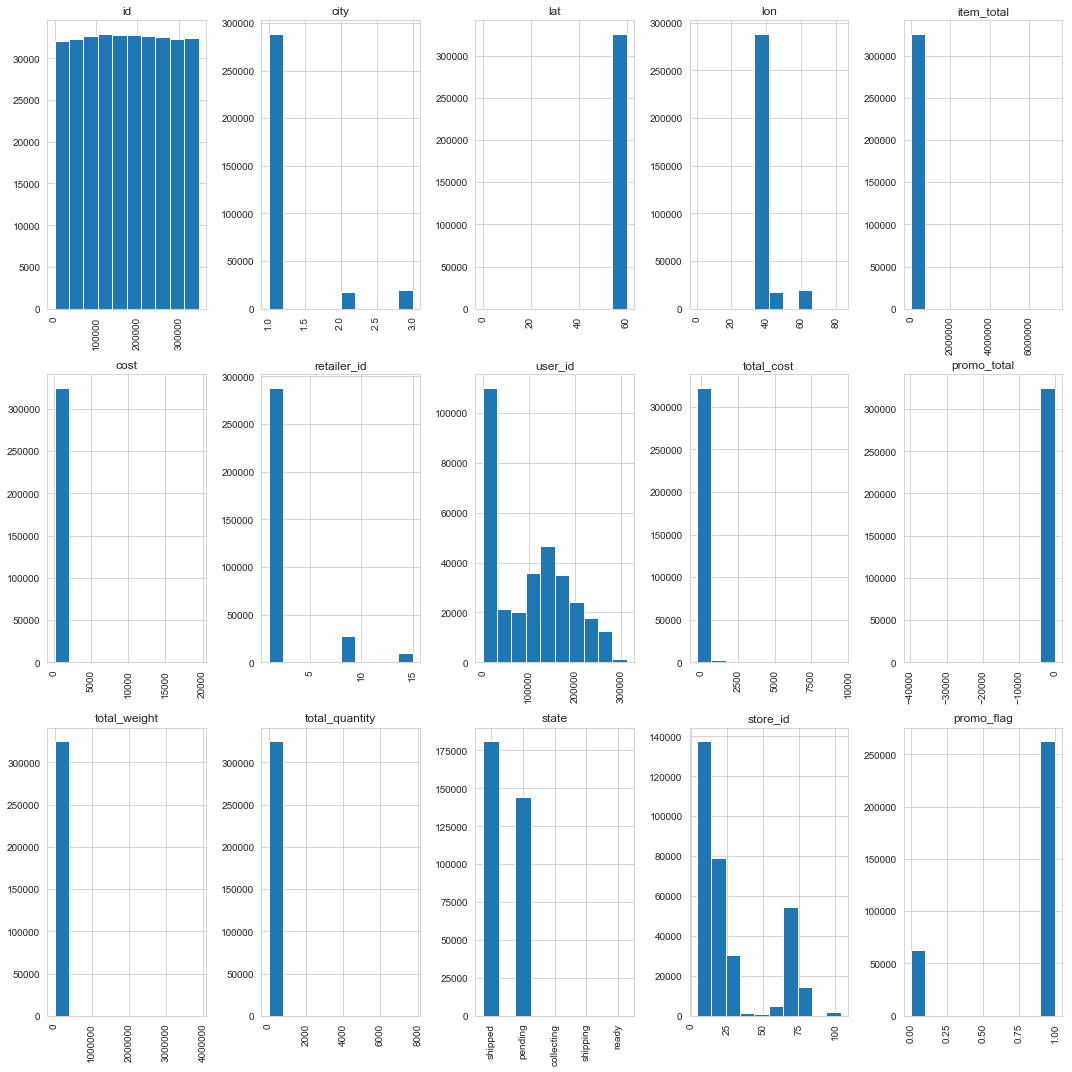

In [134]:
# Посмотрим на распределение показателей 

fig = plt.figure(figsize=(15, 15))
cols = 5
rows = np.ceil(float(data.drop(['created_at', 'shipped_at'], axis=1).shape[1]) / cols)
for i, column in enumerate(data.drop(['created_at', 'shipped_at'], axis=1)[:10].columns):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title(column)
    if data.dtypes[column] == np.object:
        data.drop(['created_at', 'shipped_at'], axis=1)[column].value_counts().plot(kind="bar", axes=ax)
    else:
        data.drop(['created_at', 'shipped_at'], axis=1)[column].hist(axes=ax)
        plt.xticks(rotation="vertical")
plt.subplots_adjust(hspace=0.7, wspace=0.2)
plt.tight_layout()

### Исследуем влияние применения промо-купона на поведение юзеров.

#### Исследуем разницу в сумме товаров (item_total).

In [116]:
data.promo_flag.value_counts()

1    262397
0     63096
Name: promo_flag, dtype: int64

Посмотрим на boxplot и убедимся, что интересно исследовать диапазон до ~8000

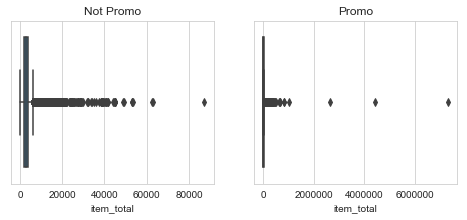

In [117]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3))
sns.boxplot(data['item_total'][data['promo_flag'] == 0], ax=axs[0])
axs[0].set_title('Not Promo')
sns.boxplot(data['item_total'][data['promo_flag'] == 1], ax=axs[1]);
axs[1].set_title('Promo');

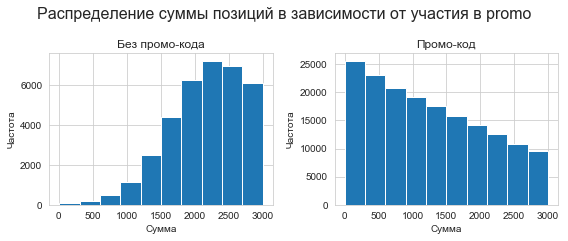

In [118]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3))
axs[0].hist(data['item_total'][(data['item_total'] < 3000) & (data['item_total'] > 0000)]\
           [data['promo_flag'] == 0])
axs[0].set_title('Без промо-кода')
axs[0].set_xlabel('Сумма')
axs[0].set_ylabel('Частота')
fig.suptitle('Распределение суммы позиций в зависимости от участия в promo', y = 1.1, fontsize=16)
axs[1].hist(data['item_total'][(data['item_total'] < 3000) & (data['item_total'] > 0000)]\
           [data['promo_flag'] == 1])
axs[1].set_xlabel('Сумма')
axs[1].set_title('Промо-код')
axs[1].set_ylabel('Частота');
fig.tight_layout()
plt.show()

В диапазоне [0, 3000] мы видим, что в категории участников промо-акции плотность распределения преобладает на значениеях близких к нулю и убывает в сторону бОльших значений. 

Предположительно промо-акция привела множество юзеров, совершающих мелкие покупки.

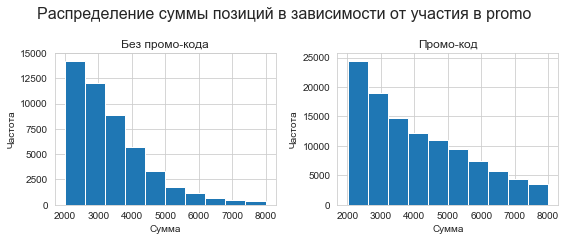

In [119]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3))
axs[0].hist(data['item_total'][(data['item_total'] < 8000) & (data['item_total'] > 2000)]\
           [data['promo_flag'] == 0])
axs[0].set_title('Без промо-кода')
axs[0].set_xlabel('Сумма')
axs[0].set_ylabel('Частота')
fig.suptitle('Распределение суммы позиций в зависимости от участия в promo', y = 1.1, fontsize=16)
axs[1].hist(data['item_total'][(data['item_total'] < 8000) & (data['item_total'] > 2000)]\
           [data['promo_flag'] == 1])
axs[1].set_xlabel('Сумма')
axs[1].set_title('Промо-код')
axs[1].set_ylabel('Частота');
fig.tight_layout()
plt.show()

В тоже время в диапазоне [2000, 8000] для участников промо-акции наблюдается увеличение плотности на учатстках более крупных покупок.

Судя по непропорциональной разнице на графиках можно предположить, что промо-акция скорее привлекает другие категории клиентов нежели заставляет покупать больше имеющиеся.

Посмотрим на распределение количества позиций в заказе:

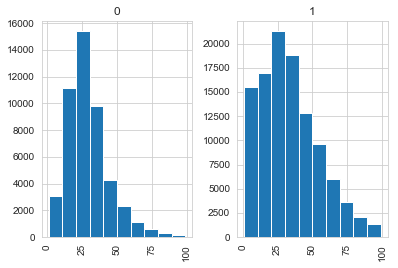

In [120]:
data['total_quantity'][data['total_quantity'] < 100][(data['item_total'] < 8000) & (data['item_total'] > 2000)].hist(by=data['promo_flag']);

В ситуации с промо-акцией наблюдается увеличение плотности на значениях 15 > x > 30

Посчитаем среднюю стоимость заказа отдельно для обычных и промо заказов:

In [121]:
data['item_total'][(data['item_total'] < 8000) & (data['item_total'] > 2000)][data['promo_flag'] == 0].mean(), \
data['item_total'][(data['item_total'] < 8000) & (data['item_total'] > 2000)][data['promo_flag'] == 1].mean()

(3379.0736496874038, 4046.0600173677944)

Взглянем на боксплот:

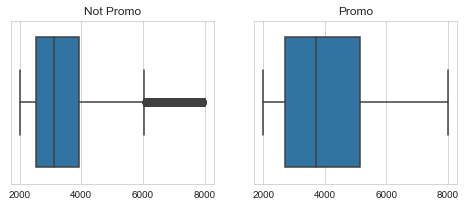

In [122]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3))
sns.boxplot(observed_frequences_not_promo, ax=axs[0])
axs[0].set_title('Not Promo')
sns.boxplot(observed_frequences_promo, ax=axs[1]);
axs[1].set_title('Promo');

Остановимся на диапазоне 2000-8000, где наблюдается увеличение суммы заказов на промо-акции. 

Хотелось бы получить статистическую значимость полученных наблюдений. Для начала проверим нормальность распределений с помощью критерия Шапиро-Уилка.

In [123]:
observed_frequences_not_promo = (data['item_total'][(data['item_total'] < 8000) & (data['item_total'] > 2000)]\
           [data['promo_flag'] == 0]).values
observed_frequences_promo = (data['item_total'][(data['item_total'] < 8000) & (data['item_total'] > 2000)]\
           [data['promo_flag'] == 1]).values

In [124]:
print('p-value = ' + str(scipy.stats.shapiro(observed_frequences_promo)[1]))
print('Примечание: для любого размера выборки вероятность ошибки первого рода 5%')

p-value = 0.0
Примечание: для любого размера выборки вероятность ошибки первого рода 5%


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1653: UserWarning:

p-value may not be accurate for N > 5000.



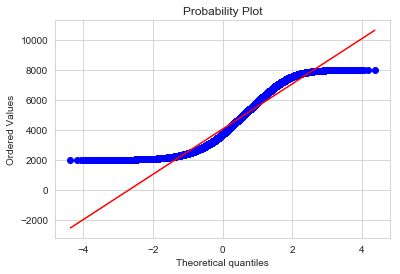

In [125]:
# Посмотрим на QQ-график и убедимся визуально, что распределение сильно отличается от нормального

fig = plt.figure()
ax = fig.add_subplot(111)
scipy.stats.probplot(observed_frequences_promo, plot=ax);

Воспользуемся непараметрическим критерием и посчитаем достигаемый уровень значимости критерия Манна-Уитни. Убедимся, что он отвергает гипотезу о том, что среднее распределений равно:

In [126]:
stats.mannwhitneyu(observed_frequences_not_promo, observed_frequences_promo)

MannwhitneyuResult(statistic=2085742514.0, pvalue=0.0)

#### Исследуем распределение ID магазинов

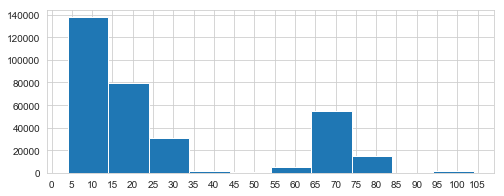

In [127]:
fig, axs = plt.subplots(1, 1, figsize=(8, 3))
data['store_id'].hist(ax=axs);
axs.set_xticks(list(range(0, 110, 5)));


Посмотрим на распределение числа заказов по дням недели.

In [135]:
data.created_at = pd.to_datetime(data.created_at)

In [136]:
data['day_of_week'] = data.created_at.apply(lambda x: x.weekday())

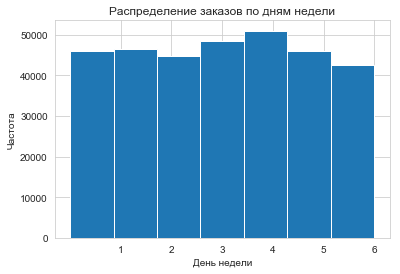

In [171]:
fig, axs = plt.subplots(1, 1)
data.day_of_week.hist(bins=7, ax=axs);
axs.set_xticks(list(range(1, 7)));
axs.set_title('Распределение заказов по дням недели');
axs.set_xlabel('День недели')
axs.set_ylabel('Частота');

Видно, что заказы распредлены более-менее равномерно по дням недели.

Посмотрим на распределение заказов в течении дня.

In [150]:
data['hour'] = data.created_at.apply(lambda x: x.hour)

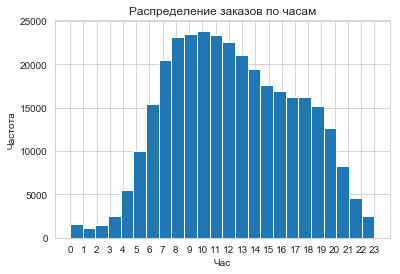

In [213]:
fig, axs = plt.subplots(1, 1)
data['hour'].hist(ax=axs, bins=24);
axs.set_xticks(list(range(0, 24)));
axs.set_title('Распределение заказов по часам');
axs.set_xlabel('Час')
axs.set_ylabel('Частота');

В любой день недели имеем пик на 10 утра, группировку вокруг этого часа, затем спад и площадку в 17-18 часов.